In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import kagglehub

c:\Users\msgal\Downloads\UCI\Classes\CS_184A\tumor_classification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [10]:
image_dir = "images"

image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

print(f"Found {len(image_paths)} images")
print(image_paths[:3])  # sanity check

Found 6 images
['images\\glioma (1).jpg', 'images\\glioma (10).jpg', 'images\\glioma (100).jpg']


In [11]:
def build_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 2)
    return model.to(device)

In [13]:
best_model = build_resnet18()

state_dict = torch.load(
    "best_resnet18.pt",
    map_location=torch.device("cpu")
)

best_model.load_state_dict(state_dict)
best_model.eval()

print("Loaded best ResNet18 model on CPU.")

Loaded best ResNet18 model on CPU.


In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [16]:
image_paths = []
labels = []

for fname in os.listdir(image_dir):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    path = os.path.join(image_dir, fname)
    fname_lower = fname.lower()

    if "healthy" in fname_lower:
        label = 0   # Healthy
    elif "glioma" in fname_lower or "tumor" in fname_lower:
        label = 1   # Tumor
    else:
        continue  # skip unknown files safely

    image_paths.append(path)
    labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total images:", len(image_paths))
print("Healthy:", np.sum(labels == 0))
print("Tumor:", np.sum(labels == 1))


Total images: 6
Healthy: 3
Tumor: 3


In [18]:
class ResNetCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x):
        self.model.zero_grad()

        logits = self.model(x)
        probs = torch.softmax(logits, dim=1)

        tumor_prob = probs[0, 1]
        tumor_prob.backward(retain_graph=True)

        A = self.activations[0]     # (C,H,W)
        dA = self.gradients[0]      # (C,H,W)

        weights = dA.mean(dim=[1,2])
        cam = torch.zeros(A.shape[1:], device=x.device)

        for c, w in enumerate(weights):
            cam += w * A[c]

        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()

In [19]:
target_layer = best_model.layer4[-1]
cam_obj = ResNetCAM(best_model, target_layer)

In [17]:
def visualize_cam(path, cam_obj):
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))
    raw_rgb = cv2.cvtColor(raw, cv2.COLOR_GRAY2RGB)

    img = Image.fromarray(raw).convert("RGB")
    tensor = val_transform(img).unsqueeze(0).to(device)

    cam = cam_obj.generate(tensor)
    cam_resized = cv2.resize(cam, (224,224))

    heat = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb, 0.5, heat, 0.5, 0)
    return raw_rgb, heat, overlay

In [20]:
healthy_idx = np.where(labels == 0)[0]
tumor_idx   = np.where(labels == 1)[0]

healthy_samples = np.random.choice(healthy_idx, 3, replace=False)
tumor_samples   = np.random.choice(tumor_idx, 3, replace=False)

sample_paths = np.concatenate([image_paths[healthy_samples],
                               image_paths[tumor_samples]])

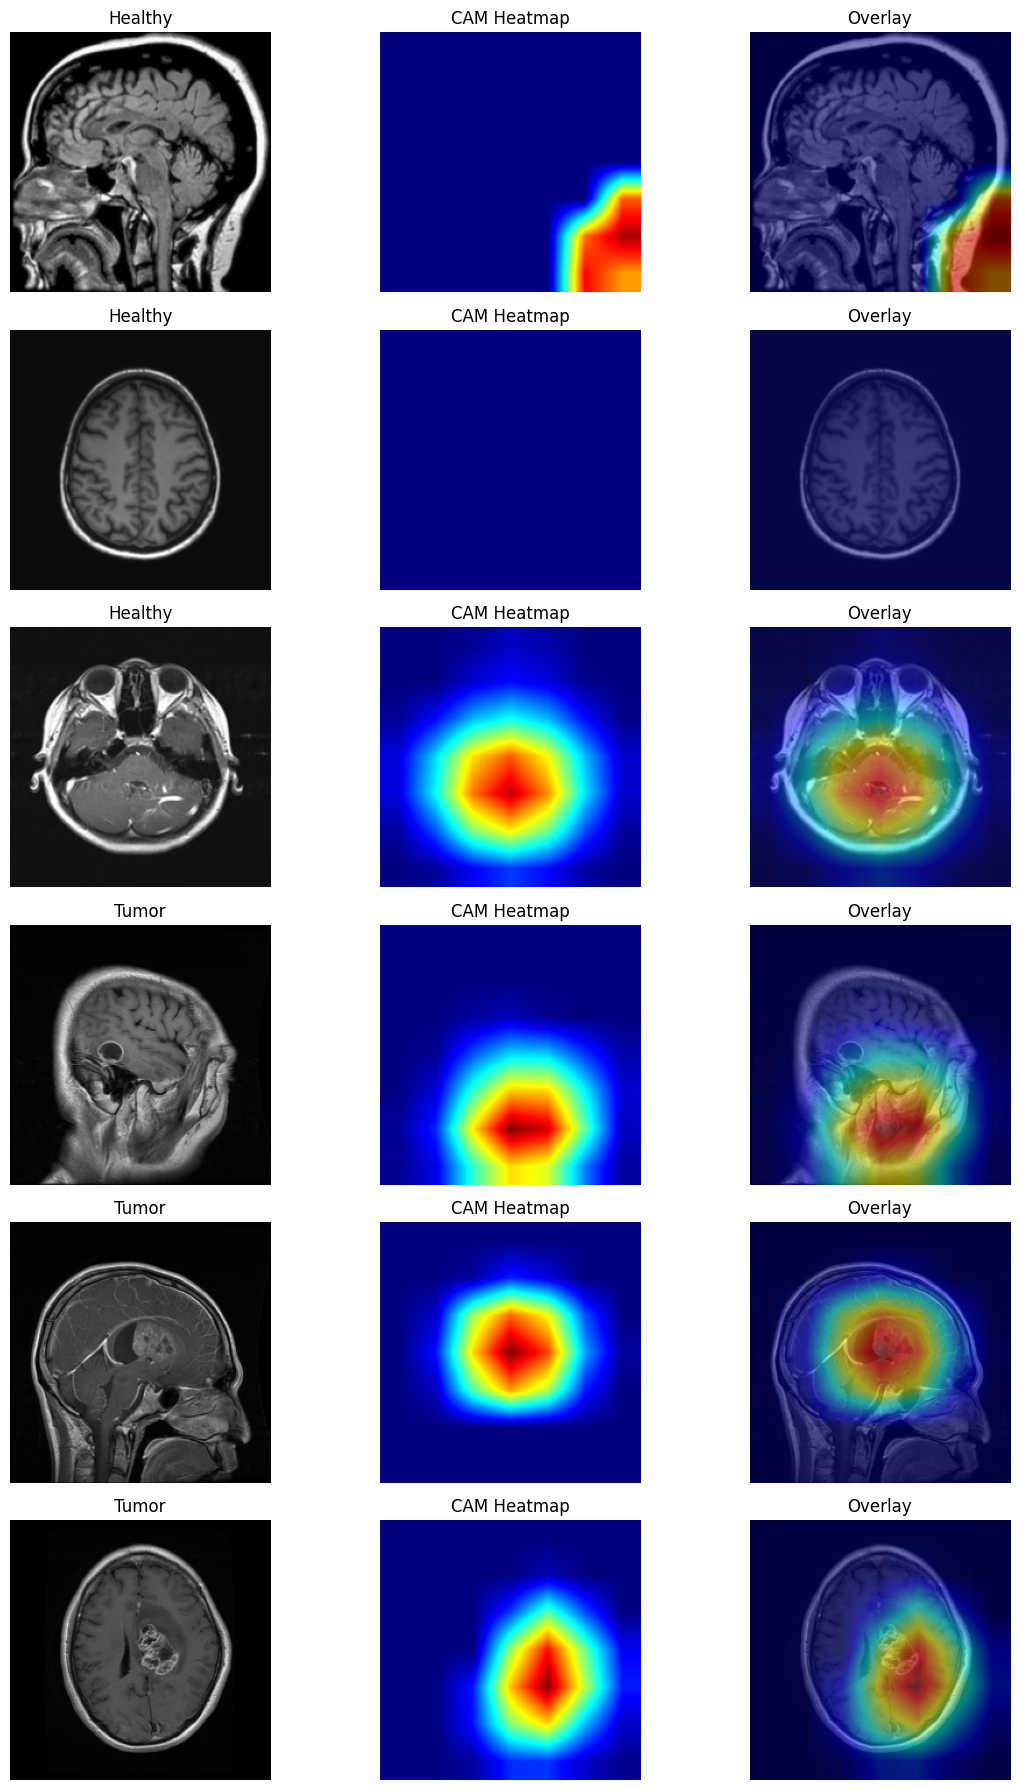

In [21]:
plt.figure(figsize=(12,18))

for i, p in enumerate(sample_paths):
    raw, heat, overlay = visualize_cam(p, cam_obj)

    plt.subplot(6,3,i*3+1)
    plt.imshow(raw)
    plt.title("Healthy" if i < 3 else "Tumor")
    plt.axis("off")

    plt.subplot(6,3,i*3+2)
    plt.imshow(heat)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(6,3,i*3+3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
def cam_focus_score(cam):
    k = int(cam.size * 0.2)
    top = np.partition(cam.flatten(), -k)[-k:]
    return top.mean()

all_cam_scores = []
all_confidences = []
all_labels = []

for path, label in zip(image_paths, labels):
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))

    img = Image.fromarray(raw).convert("RGB")

    tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = best_model(tensor)
        prob = torch.softmax(logits, dim=1)[0,1].item()

    cam = cam_obj.generate(tensor)

    score = cam_focus_score(cam)

    all_confidences.append(prob)
    all_cam_scores.append(score)
    all_labels.append(label)


In [23]:
all_cam_scores = np.array(all_cam_scores)
all_confidences = np.array(all_confidences)
all_labels = np.array(all_labels)

In [24]:
healthy_scores = all_cam_scores[all_labels == 0]
tumor_scores   = all_cam_scores[all_labels == 1]

In [25]:
corr = np.corrcoef(all_confidences, all_cam_scores)[0,1]

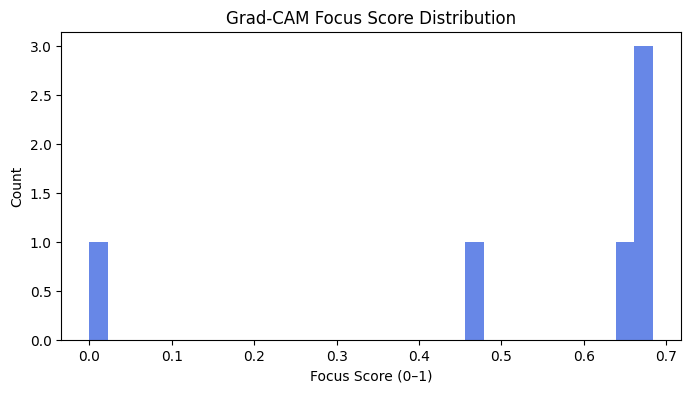

In [26]:
plt.figure(figsize=(8,4))
plt.hist(all_cam_scores, bins=30, color="royalblue", alpha=0.8)
plt.title("Grad-CAM Focus Score Distribution")
plt.xlabel("Focus Score (0–1)")
plt.ylabel("Count")
plt.show()

C:\Users\msgal\AppData\Local\Temp\ipykernel_33500\582394981.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])


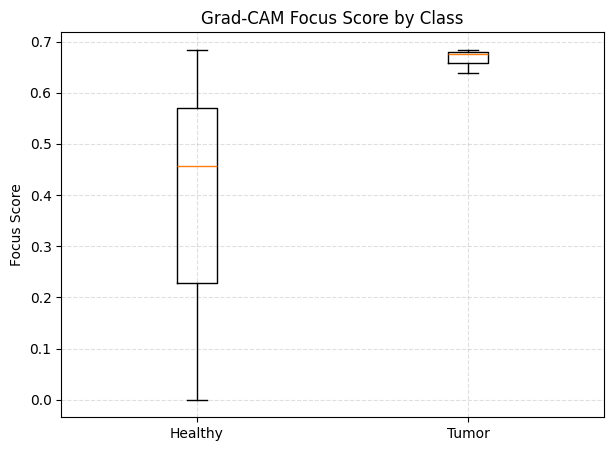

In [27]:
plt.figure(figsize=(7,5))
plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])
plt.title("Grad-CAM Focus Score by Class")
plt.ylabel("Focus Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

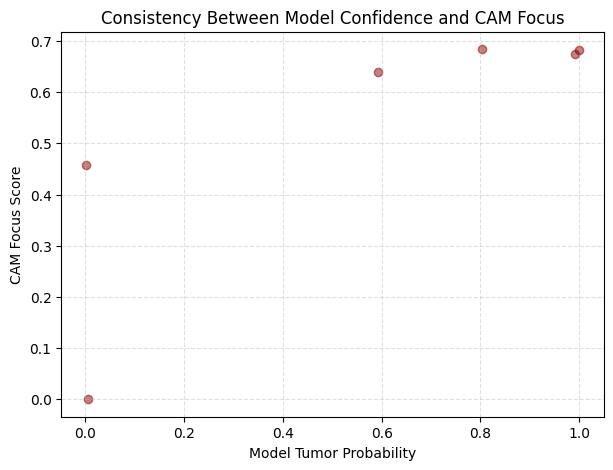

In [28]:
plt.figure(figsize=(7,5))
plt.scatter(all_confidences, all_cam_scores, alpha=0.5, color="darkred")
plt.xlabel("Model Tumor Probability")
plt.ylabel("CAM Focus Score")
plt.title("Consistency Between Model Confidence and CAM Focus")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [29]:
print("=== UPDATED GRAD-CAM SUMMARY ===")
print("Correlation (Confidence ↔ CAM):", corr)
print("Healthy CAM Mean:", healthy_scores.mean())
print("Tumor CAM Mean:", tumor_scores.mean())

=== UPDATED GRAD-CAM SUMMARY ===
Correlation (Confidence ↔ CAM): 0.812385170477068
Healthy CAM Mean: 0.3800057
Tumor CAM Mean: 0.6661809
